Import necessary packages and build connections to postgre sql.

In [2]:
from sqlalchemy import create_engine 
from sqlalchemy_utils import database_exists, create_database
import psycopg2 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import collections 
import pylab as plb

In [3]:
dbname = 'kure' 
username = 'kure' 
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname)) 
print(engine.url)  
# connect: con = None con = psycopg2.connect(database = dbname, user = username) 

postgres://kure@localhost/kure


In [8]:
# connect: 
con = None 
con = psycopg2.connect(database = dbname, user = username)  
sql_query_post_street = """ 
SELECT * FROM post_street_all; """ 
post_street = pd.read_sql_query(sql_query_post_street,con) 
post_street.head()

,id,case_id,doc_id,doc_type,cpt,asc_med,doc_med,total_med
0,1,1,1,ORT,27036,0.000000,1139.92,1139.920000
1,2,1,1,ORT,29914,3430.734978,1128.27,4559.004978
2,3,1,1,ORT,29916,4874.772730,1150.28,6025.052730
3,4,2,2,ORT,29881,1848.486442,621.38,2469.866442
4,5,2,2,ORT,27403,1122.907424,727.87,1850.777424


In [9]:
# find the total price for each case_id 
ps_id_fee = post_street.drop(post_street.columns[[0,2,3,5,6]],axis = 1) 
ps_combined = ps_id_fee.groupby('case_id', sort = False)['cpt'].apply(' / '.join) 
ps_combined = [x.split(' / ') for x in ps_combined] 
ps_id_fee = ps_id_fee.drop('cpt',axis = 1) 
ps_per_id = ps_id_fee.groupby("case_id",sort=False).sum() 
ps_per_id['cpt_list'] = ps_combined
ps_per_id.head()

,total_med,cpt_list
case_id,,
1,11723.977708,"[27036, 29914, 29916]"
2,4320.643866,"[29881, 27403]"
3,5615.271996,"[25000, 64776, 26500]"
4,7312.510308,"[26860, 26480, 25447]"
5,14467.462840,"[29823, 29824, 29826, 29828, 29827]"


In [10]:
# find the cpt code for each case_id  
ps_id_cpt = post_street.drop(post_street.columns[[0,2,3,5,6]],axis = 1)
# group the dataframe by case id and have a list of combination code and price
ps_by_id = ps_id_cpt.groupby('case_id').agg(lambda x: x.tolist()).reset_index()
# find the most expensive code and append to the single cpt code list and calculate the total price for that case id
single_cpt_list = [] 
total_fee_list = [] 
for i in range(len(ps_by_id)):     
    index = ps_by_id['total_med'][i].index(max(ps_by_id['total_med'][i]))     
    single_cpt_list.append(ps_by_id['cpt'][i][index])     
    total_fee_list.append(sum(ps_by_id['total_med'][i]))
ps_by_id['single_code'] = single_cpt_list 
ps_by_id['sum_fee'] = total_fee_list
ps_by_id.head()

,case_id,cpt,total_med,single_code,sum_fee
0,1,"[27036, 29914, 29916]","[1139.92, 4559.004978, 6025.05273]",29916,11723.977708
1,2,"[29881, 27403]","[2469.866442, 1850.777424]",29881,4320.643866
2,3,"[25000, 64776, 26500]","[1517.767424, 1523.53813, 2573.966442]",26500,5615.271996
3,4,"[26860, 26480, 25447]","[2514.086442, 2006.187424, 2792.236442]",25447,7312.510308
4,5,"[29823, 29824, 29826, 29828, 29827]","[2559.786442, 2615.916442, 193.29, 4467.774978...",29827,14467.462840


In [12]:
# create a new dataframe and assign it with ps_by_id
ps_ave_cpt = ps_by_id 
# calculate the average fee by averaging all the cases with the same single code
count = ps_ave_cpt.groupby('single_code').count() 
ps_ave_cpt = ps_ave_cpt.groupby('single_code').agg(lambda x: x.tolist()).reset_index() 
count_list = count['case_id'].tolist() 
# calculate the average total fee per single code
average_fee_list = [] 
for i in range(len(ps_ave_cpt)):     
    average_fee_list.append(np.mean(ps_ave_cpt['sum_fee'][i])) 
ps_ave_cpt['average_fee'] = average_fee_list      
ps_plan = ps_ave_cpt.drop(ps_ave_cpt.columns[[1,2,3,4]],axis=1) 
ps_plan['count'] = count_list 
old_average_fee = ps_plan['average_fee']
ps_plan.to_csv('/home/ubuntu/Insight Data Science/Kure Health/old_single_code_fee', sep=',')
ps_plan.head()

,single_code,average_fee,count
0,10120,267.705038,6
1,10121,1590.494930,4
2,11042,243.946787,1
3,11043,503.322030,3
4,11044,981.508526,1


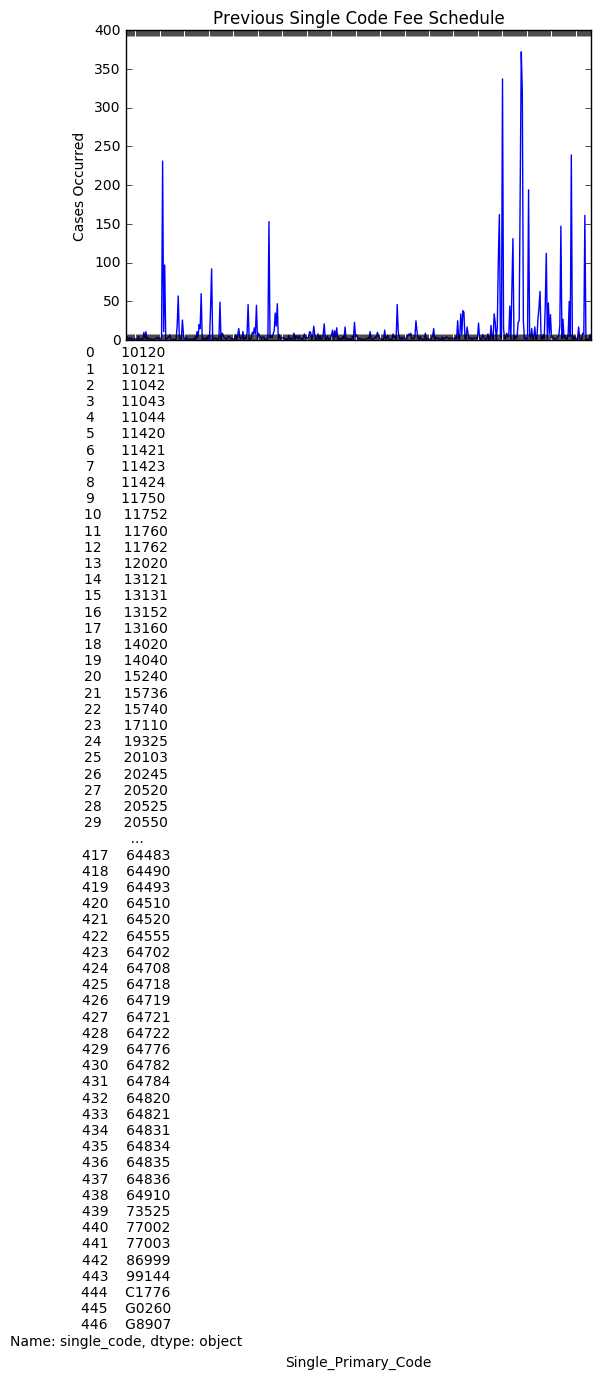

In [13]:
# plot the repeating frequencies of all single codes
x = range(len(ps_plan)) 
my_ticks = [ps_plan['single_code']] 
plb.figure(1) 
plb.xticks(x,my_ticks) 
plb.plot(x, ps_plan['count']) 
plb.xlabel('Single_Primary_Code') 
plb.ylabel('Cases Occurred') 
plb.title('Previous Single Code Fee Schedule') 
plb.show() 

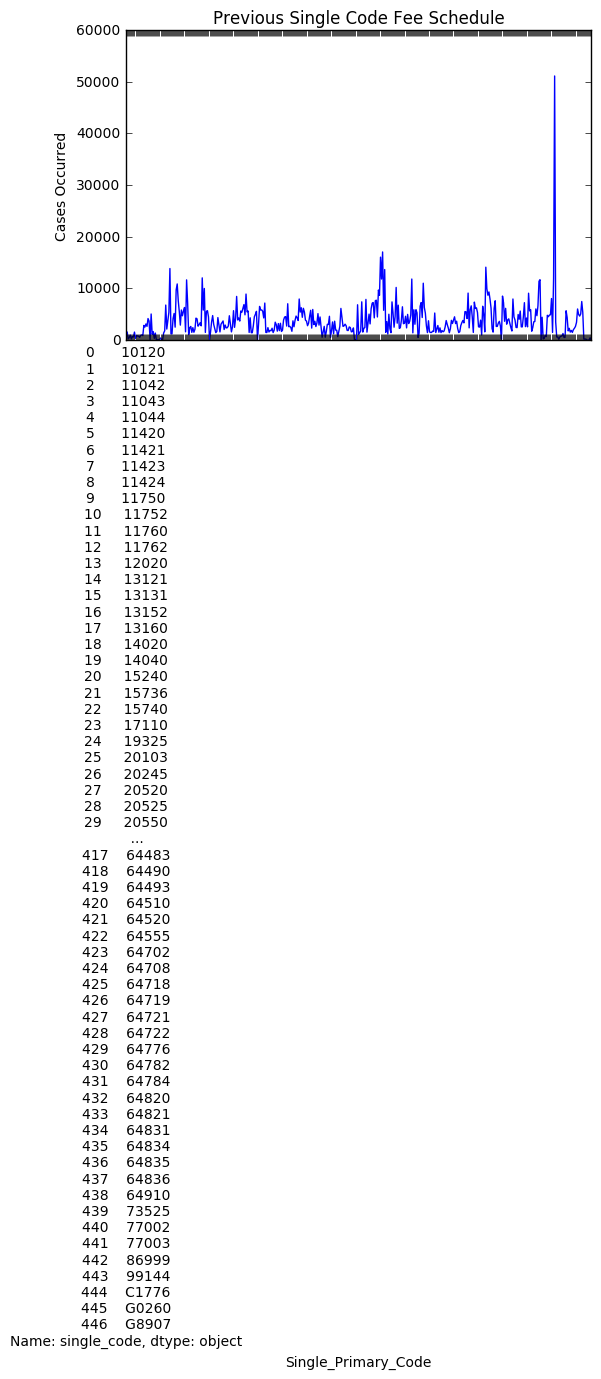

In [14]:
# plot the price of all single codes
plb.figure(1) 
my_ticks = [ps_plan['single_code']] 
plb.xticks(x,my_ticks) 
plb.plot(x, old_average_fee) 
plb.xlabel('Single_Primary_Code') 
plb.ylabel('Cases Occurred') 
plb.title('Previous Single Code Fee Schedule') 
plb.show()

In [15]:
# Calculate the total fee for each case id by not simply sum them up but add a discount factor of 1/2 for the 2nd duplicate, 1/4 for the 3rd, ...
# for those duplicate codes cases
duplicate_index = [] 
new_sum_price = [] 
duplicate_cpt = [] 
new_single_cpt_list = [] 
ps_by_id_dup = ps_by_id
for i in range(len(ps_by_id_dup)):     
    duplicate_list = []     
    duplicate_list = list(set(x for x in ps_by_id_dup['cpt'][i] if ps_by_id_dup['cpt'][i].count(x) > 1))     
    if duplicate_list:         
        sum_price = []
        count = 0
        for j in range(len(duplicate_list)):             
            count += ps_by_id_dup['cpt'][i].count(duplicate_list[j])
            index = ps_by_id_dup['cpt'][i].index(duplicate_list[j])             
            cpt_price = ps_by_id_dup['total_med'][i][index]             
            sum_price.append(cpt_price*(2-(0.5)**(count-1)))             
            duplicate_cpt.append(duplicate_list[j])  
        if len(ps_by_id_dup['cpt'][i]) > count:
            for k in range(count,len(ps_by_id_dup['cpt'][i])):
                sum_price.append(ps_by_id_dup['total_med'][i][k])
                duplicate_list.append(ps_by_id_dup['cpt'][i][k])
        index_2 = sum_price.index(max(sum_price))         
        new_single_cpt_list.append(duplicate_list[index_2])         
        ps_by_id_dup.loc[i,['sum_fee']] = sum(sum_price)         
        duplicate_index.append(i)         
        new_sum_price.append(sum(sum_price))  
# the duplicate codes takes very small part of the whole case ids as shown below, therefore, only the dupicate codes session
# should be plotted for visualization purpose
duplicate_percentage = len(duplicate_index)/float(len(ps_by_id_dup))*100
print duplicate_percentage
ps_by_id_dup.head()

3.32065029402


,case_id,cpt,total_med,single_code,sum_fee
0,1,"[27036, 29914, 29916]","[1139.92, 4559.004978, 6025.05273]",29916,11723.977708
1,2,"[29881, 27403]","[2469.866442, 1850.777424]",29881,4320.643866
2,3,"[25000, 64776, 26500]","[1517.767424, 1523.53813, 2573.966442]",26500,5615.271996
3,4,"[26860, 26480, 25447]","[2514.086442, 2006.187424, 2792.236442]",25447,7312.510308
4,5,"[29823, 29824, 29826, 29828, 29827]","[2559.786442, 2615.916442, 193.29, 4467.774978...",29827,14467.462840


In [17]:
# group by id and average the total fee  
ps_new_ave_cpt = ps_by_id_dup 
count = ps_new_ave_cpt.groupby('single_code').count() 
ps_new_ave_cpt = ps_new_ave_cpt.groupby('single_code').agg(lambda x: x.tolist()).reset_index() 
count_list = count['case_id'].tolist()  
average_fee_list = []        
for i in range(len(ps_new_ave_cpt)):     
    average_fee_list.append(np.mean(ps_new_ave_cpt['sum_fee'][i])) 
ps_new_ave_cpt['average_fee'] = average_fee_list                   
ps_new_plan = ps_new_ave_cpt.drop(ps_new_ave_cpt.columns[[1,2,3,4]],axis=1) 
ps_new_plan['count'] = count_list  
new_average_fee = ps_new_plan['average_fee']
ps_plan.to_csv('/home/ubuntu/Insight Data Science/Kure Health/new_single_code_fee', sep=',')
ps_new_plan.head()

,single_code,average_fee,count
0,10120,267.705038,6
1,10121,1590.494930,4
2,11042,243.946787,1
3,11043,503.322030,3
4,11044,981.508526,1


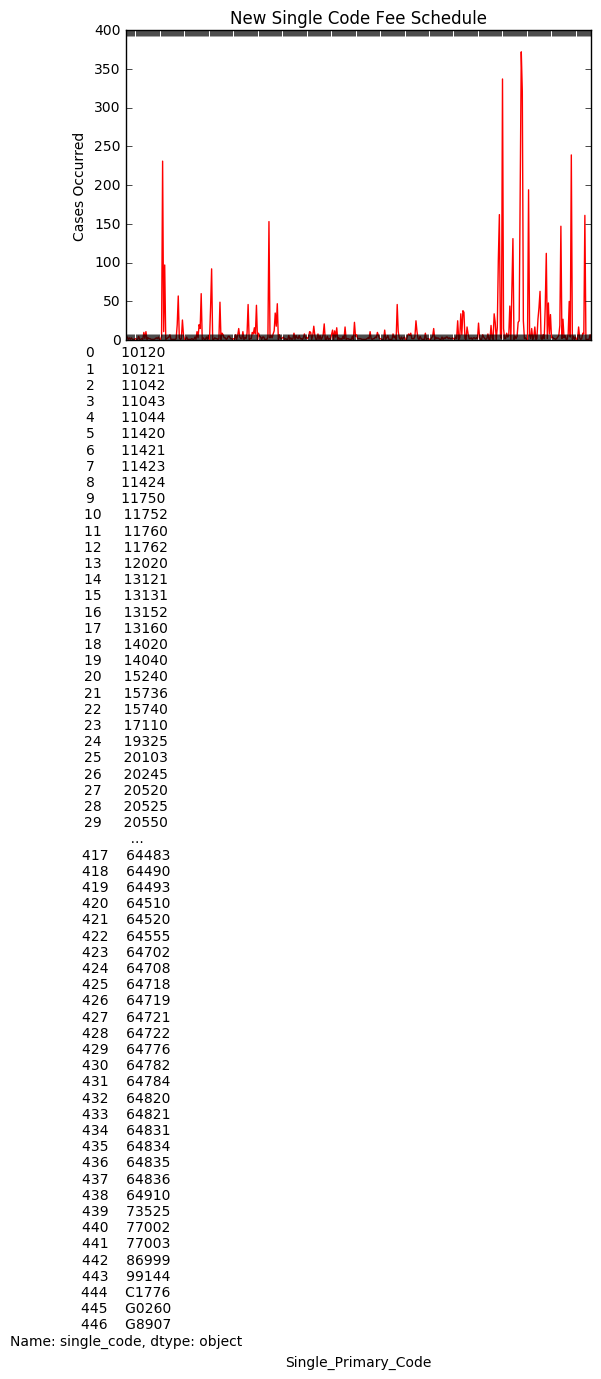

In [18]:
# plot the new fee schedule
x = range(len(ps_new_plan)) 
my_ticks = [ps_new_plan['single_code']] 
plb.figure(1) 
plb.xticks(x,my_ticks) 
plb.plot(x, ps_new_plan['count'], 'r') 
plb.xlabel('Single_Primary_Code') 
plb.ylabel('Cases Occurred') 
plb.title('New Single Code Fee Schedule') 
plb.show() 

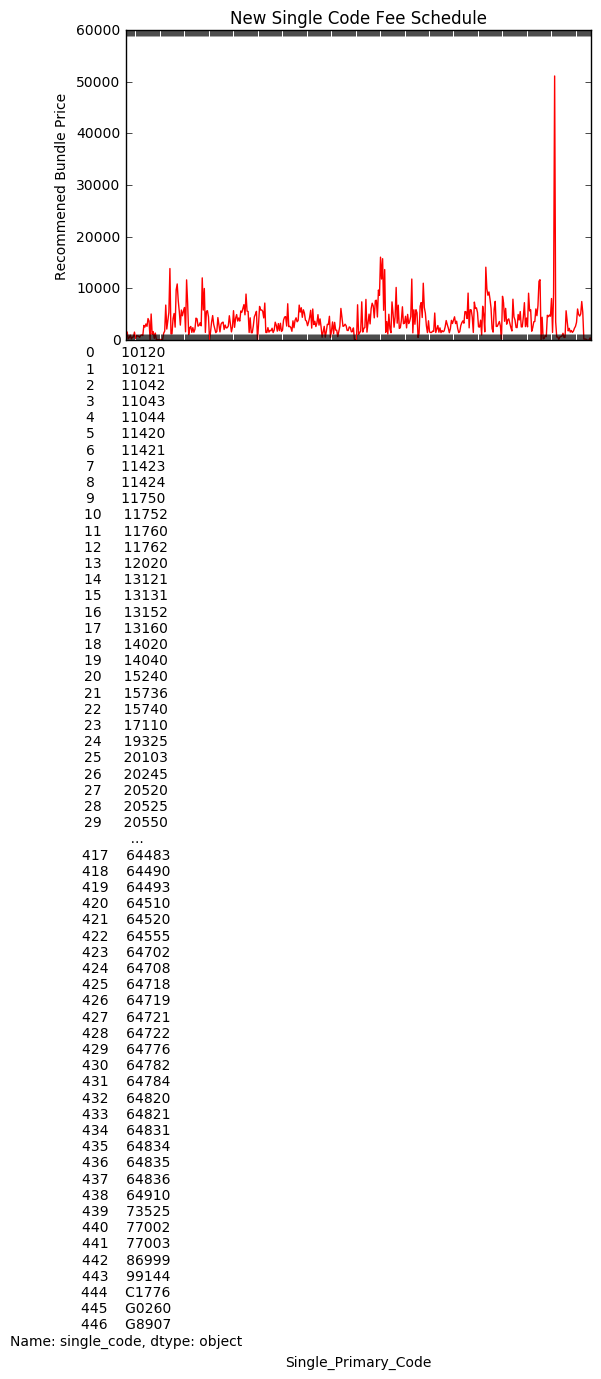

In [19]:
plb.figure(1) 
my_ticks = [ps_new_plan['single_code']] 
plb.xticks(x,my_ticks) 
plb.plot(x, new_average_fee, 'r') 
plb.xlabel('Single_Primary_Code') 
plb.ylabel('Recommened Bundle Price') 
plb.title('New Single Code Fee Schedule') 
plb.show()

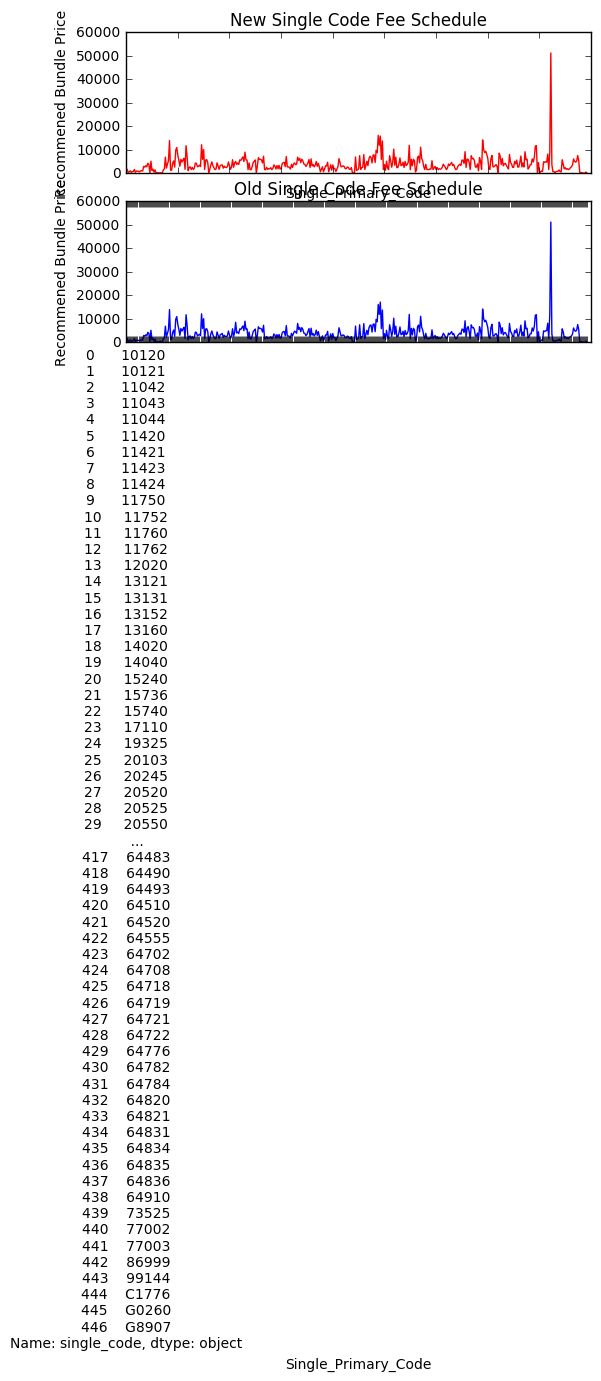

In [20]:
# compare the two fee schedules
plb.figure(1) 
plb.subplot(2,1,1) 
ax = plt.gca() 
ax.set_xticklabels([]) 
plb.plot(x, new_average_fee, 'r') 
plb.xlabel('Single_Primary_Code') 
plb.ylabel('Recommened Bundle Price') 
plb.title('New Single Code Fee Schedule') 
plb.subplot(2,1,2) 
plb.plot(x, old_average_fee, 'b') 
my_ticks = [ps_new_plan['single_code']] 
plb.xticks(x,my_ticks) 
plb.xlabel('Single_Primary_Code') 
plb.ylabel('Recommened Bundle Price') 
plb.title('Old Single Code Fee Schedule') 
plb.show() 

In [21]:
# because the duplicate codes is only 3.8% of occurance of the whole cases it would be nice to visualize only the change
# by applying the new fee calculation by only looking at the duplicate codes
duplicate_ps_new = ps_by_id_dup.ix[duplicate_index]   
count = duplicate_ps_new.groupby('single_code').count() 
duplicate_ps_new = duplicate_ps_new.groupby('single_code').agg(lambda x: x.tolist()).reset_index() 
count_list = count['case_id'].tolist()  
average_fee_list = []        
for i in range(len(duplicate_ps_new)):     
    average_fee_list.append(np.mean(duplicate_ps_new['sum_fee'][i])) 
duplicate_ps_new['average_fee'] = average_fee_list                   
ps_new_plan_duplicate = duplicate_ps_new.drop(duplicate_ps_new.columns[[1,2,3,4]],axis=1) 
ps_new_plan_duplicate['count'] = count_list  
new_duplicate_average_fee = duplicate_ps_new['average_fee'] 
new_duplicate_count = ps_new_plan_duplicate['count'] 
new_duplicate_cpt = ps_new_plan_duplicate['single_code'] 
ps_new_plan_duplicate.head()
duplicate_ps_new.head()

,single_code,case_id,cpt,total_med,sum_fee,average_fee
0,11421,[6549],"[[11420, 11420, 11421]]","[[209.651529, 209.651529, 263.331718]]",[577.8090115],577.809011
1,20600,[6587],"[[20600, 20600, 20600, 20600, 20600, 20600]]","[[70.750544, 70.750544, 70.750544, 70.750544, ...",[139.2901335],139.290133
2,20605,[5867],"[[20605, 20605]]","[[74.583801, 74.583801]]",[111.8757015],111.875701
3,20610,"[156, 473, 850, 1574, 5506, 6260, 6292, 6412, ...","[[20610, 20610], [20610, 20610], [20610, 20610...","[[90.9771, 90.9771], [90.9771, 90.9771], [90.9...","[136.46565, 136.46565, 136.46565, 136.46565, 1...",156.682783
4,20670,[5687],"[[20670, 20670]]","[[1263.133915, 1263.133915]]",[1894.7008725],1894.700872


In [22]:
# perform the same operation to the old fee schedule by only looking at the duplicate code cases
duplicate_ps_old = ps_by_id.ix[duplicate_index]  
count = duplicate_ps_old.groupby('single_code').count() 
duplicate_ps_old = duplicate_ps_old.groupby('single_code').agg(lambda x: x.tolist()).reset_index() 
count_list = count['case_id'].tolist() 
average_fee_list = [] 
for i in range(len(duplicate_ps_old)):     
    average_fee_list.append(np.mean(duplicate_ps_old['sum_fee'][i])) 
duplicate_ps_old['average_fee'] = average_fee_list      
ps_plan_duplicate_old = duplicate_ps_old.drop(duplicate_ps_old.columns[[1,2,3,4]],axis=1) 
ps_plan_duplicate_old['count'] = count_list 
old_duplicate_average_fee = ps_plan_duplicate_old['average_fee'] 
old_duplicate_count = ps_plan_duplicate_old['count'] 
ps_plan_duplicate_old.head()

,single_code,average_fee,count
0,11421,577.809011,1
1,20600,139.290133,1
2,20605,111.875701,1
3,20610,156.682783,9
4,20670,1894.700872,1


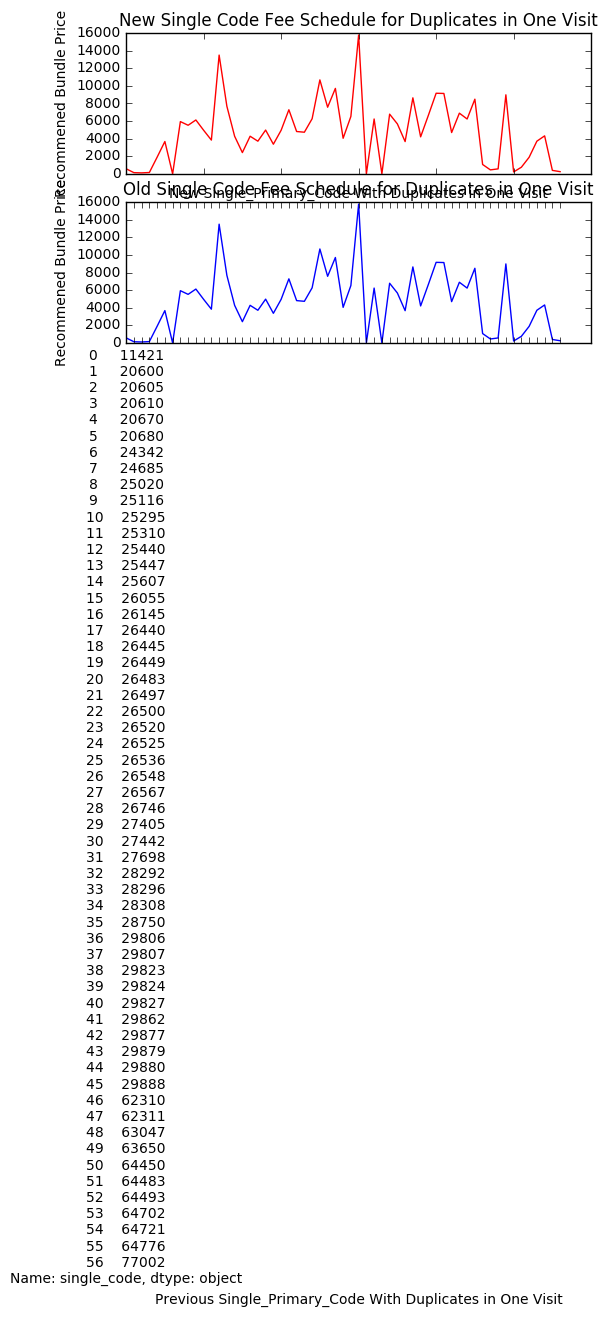

In [23]:
# plot the old and new fee schedule of only the duplicate code sesesion
plb.figure(1) 
x = range(len(new_duplicate_cpt)) 
plb.subplot(2,1,1) 
ax = plt.gca() 
ax.set_xticklabels([]) 
plb.plot(x, new_duplicate_average_fee, 'r') 
plb.xlabel('New Single_Primary_Code With Duplicates in One Visit') 
plb.ylabel('Recommened Bundle Price') 
plb.title('New Single Code Fee Schedule for Duplicates in One Visit') 
plb.subplot(2,1,2) 
plb.plot(x, old_duplicate_average_fee, 'b')  
my_ticks = [new_duplicate_cpt] 
plb.xticks(x,my_ticks) 
plb.xlabel('Previous Single_Primary_Code With Duplicates in One Visit') 
plb.ylabel('Recommened Bundle Price') 
plb.title('Old Single Code Fee Schedule for Duplicates in One Visit') 
plb.show()

Plot the frequencies of CPT codes in the surgical center.

In [26]:
sql_query_post_street_cut = """
SELECT * FROM post_street;
"""
post_street_cut = pd.read_sql_query(sql_query_post_street_cut,con)
post_street_cut = post_street_cut[['cpt','total_med']]
post_street_cut = post_street_cut.groupby('cpt').mean()
post_street_cut.head()

,total_med
cpt,
0232T,0.000000
10120,267.705038
10121,1302.203915
10140,277.934996
11010,1041.488526


In [37]:
cpt_list = list(post_street['cpt'])
import collections
from operator import itemgetter
counter = collections.Counter(cpt_list)
print(counter.most_common(10))
counter_sorted = sorted(counter.items(),key=itemgetter(1), reverse = True)
counter_df = pd.DataFrame(counter_sorted)
counter_df.columns = ['cpt','frequencies']

ps_gp_cpt = post_street[['cpt', 'total_med']].groupby("cpt",sort=False).mean()
counter_df.head()

[('C1713', 980), ('29826', 713), ('29881', 540), ('29880', 528), ('20610', 432), ('29824', 382), ('G8907', 381), ('64721', 359), ('29827', 337), ('29823', 325)]


,cpt,frequencies
0,C1713,980
1,29826,713
2,29881,540
3,29880,528
4,20610,432


In [38]:
price = []
for i in range(len(counter_df['cpt'])):
    price.append(ps_gp_cpt.loc[counter_df['cpt'][i], 'total_med'])
counter_df['price'] = price
zero_index = counter_df[counter_df['price'] == 0].index.tolist()
counter_df = counter_df.drop(counter_df.index[zero_index])

counter_df_cpt = counter_df['cpt'].tolist()
cpt_comb_list = []
for i in range(len(counter_df)):
    list0 = []
    for j in range(len(ps_combined)):
        if counter_df_cpt[i] in ps_combined[j]:
            list0.extend(ps_combined[j])
    list0 = list(set(list0))
    list0.remove(counter_df_cpt[i])
    cpt_comb_list.append(list0)

counter_df['associated_codes'] = cpt_comb_list

n=50
cpt_comb_list_n=[]
cpt_comb_list_n = [filter(lambda x: x in list(counter_df['cpt'][:n]), sublist) for sublist in cpt_comb_list[:n]]
counter_df_n = counter_df[:n]
counter_df_n['filtered_assoc_codes'] = cpt_comb_list_n
counter_df_n.head()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,cpt,frequencies,price,associated_codes,filtered_assoc_codes
1,29826,713,193.290000,"[29880, 23670, 20610, 64415, 23120, G8916, 234...","[29880, 20610, 64415, 29877, 23430, 29823, 298..."
2,29881,540,2469.866442,"[29880, 29882, 27599, 29888, 64415, 27540, 206...","[29880, 29882, 29888, 64415, 20610, 29879, 298..."
3,29880,528,2492.406442,"[29881, 20610, 29888, G8916, G8918, G0289, 275...","[29881, 20610, 29888, 29879, 29824, 29877, 298..."
4,20610,432,90.977100,"[29880, 29881, 29884, 29862, 29863, 77003, 770...","[29880, 29881, 29862, 29863, 77003, 77002, 644..."
5,29824,382,2615.916442,"[29880, 20610, 64415, 23075, G8916, 23440, G89...","[29880, 20610, 64415, 29877, 29823, 23430, 298..."


Write the json file of all the connected CPT codes using python.

In [39]:
import os
text_file = open("/home/ubuntu/Insight Data Science/Kure Health/data_js_top%d.txt" %n, "w")
for i in range(len(counter_df_n)):
    text_file.write('{"name": "%s", "imports": [' % list(counter_df_n['cpt'])[i])
    text_file.writelines("'%s'," % item for item in list(counter_df_n['filtered_assoc_codes'])[i])
    text_file.seek(-1, os.SEEK_END)
    text_file.truncate()
    text_file.write(']},\n')
text_file.close()

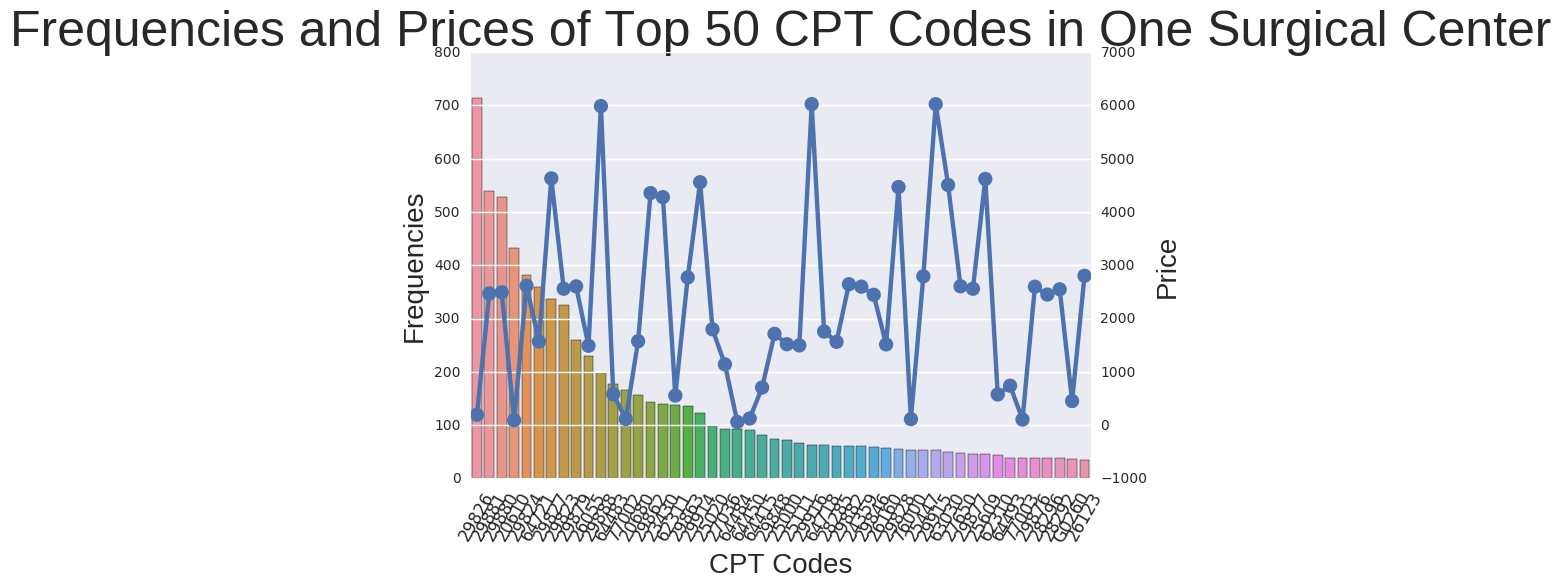

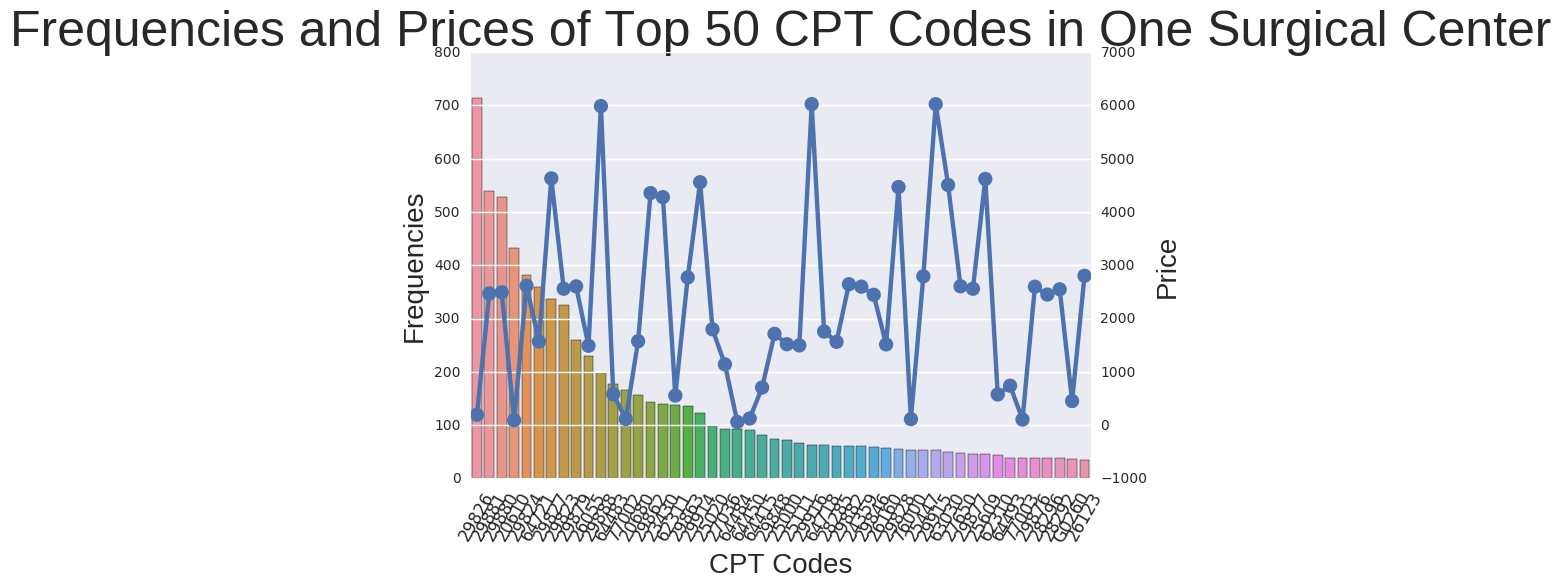

In [42]:
import seaborn as sns
n = 50
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
sns.barplot(x='cpt', y = 'frequencies', data = counter_df[:n], ax = ax1)
sns.pointplot(x='cpt', y = 'price', data = counter_df[:n], ax = ax2)
plt.sca(ax1)
plt.xticks(rotation=60, fontsize = 12)
ax1.set_xlabel('CPT Codes',fontsize = 20)
ax1.set_ylabel('Frequencies', fontsize = 20) 
ax2.set_ylabel('Price', fontsize = 20) 
plt.title('Frequencies and Prices of Top %d CPT Codes in One Surgical Center' % n, fontsize = 36)
